# Neuhaus et al 2021 Radiocarbon Model

In [Neuhaus et al., 2021](https://tc.copernicus.org/articles/15/4655/2021/tc-15-4655-2021-supplement.pdf), the authors use molecular diffisuvity models, borehole temperature, and some measurements of borehole salt content to model the timing of retreat and readvance of the West Antarctic Ice Sheet during the early Holocene. Then, they use the windows of time that the borehole sites were open to model the radiocarbon age of the sediment using a peculiar method of constant supply of $^{12}C$ and supply of $^{14}C$ only when the area was connected to the ocean, i.e. seaward of the grounding line. 

Here we emulate their borehole temperature model and adjust for SLM variables and measurements. 

In the cells below, we import packages and initialize the model as they derived it in order to perform sensitivity tests of the radiocarbon age. The goal is to assess radiocarbon age based on their model in comparison with measured radiocarbon ages and derived maximum age of readvance of the WAIS from [Venturelli et al., 2023](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022AV000846). The measured age constraint was measured after this model was published, therefore it could not be used as an additional constraint. 

In [1]:
#Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import neuhaus_fcns as nf       #Functions to generate original plots easily. 

#Set up initial radiocarbon conditions
t_earliest = 8000       #earliest possible time the grounding line could have retreated behind field sites (same for SLM?)
n_0 = 0                 #Initial amount of 14C in the sediment, prior to Holocene retreat.
Fm_max = math.exp(-1000/8033)
                        #Fraction modern of the "modern" isopod carbon measured at the Whillans Grounding Zone
t_readvance = 4000      #Calendar years before present of ice sheet retreat poleward of SLM
ti = 4000               #Calendar years before present of ice sheet readvance seaward of SLM
a = 9.23*10**(-18)      #Accumulation rate of 14C, g/yr/100g sediment
A = 9*10**(-6)          #Accumulation rate of 12C, g/yr/100g sediment
N_0 = 0.28              #Non-zero initial condition of %TOC (g/100g sediment)
tau = 8033              #mean lifetime of 14C based off of the Libby half life.
modern_ratio = 1.176810*10**(-12)
                        #Modern ratio of 14C/12C to transform to fraction modern - from the Neuhaus et al. text. 

#Set up initial temperature model conditions
S = 34                  #PSU
ice_acc_rate = 0.15     #m/yr, Waddington et al, 2005
surf_T = -25            #temperature at the surface of the ice (Engelhardt, 2004)





## Temperature profiles in the ice

Neuhaus et al., 2020, breaks from convention in assuming that observed unsteady thermal states in vertical temperature profiles in Siple Coast ice are due to Holocene ice shelf re-grounding in the region. Previous workers had constrained the reasons for this temperature profiles to:
    1. cooling the surface temperature
    2. increasing the vertical advection (accumulation)
    3. increasing the horizontal advection (ice velocity)
Engelhardt settled on horizontal advection (2004), but was unable to reproduce the high basal temperature gradients wihout invoking basal melt.

Neuhaus et al. 2020 assume that this area was a grounded ice shelf in the past, an assumption supported by Kingslake et al. 2018 paper. They focused on Kamb Ice Stream, Bindschadler Ice Stream, and Unicorn due to very steep basal temperature gradients. Temperature gradients were modeled before and after grounding as in Bindschadler et al., 1990. The modeled basal temperaure gradients were compared to the observed (Engelhardt, 2004). The following cells aim to model the temperature profile through the ice, first using all boundary conditions and assumptions of Neuhaus et al., and then changing to those likely or measured for SLM. 

### Phase 1: Floating ice
The model is run with a 1 year time step and a 10m vertical spatial step. This is to satisfy the von Neumann stability condition. A constant surface temperature of -25 C is used and a bottom temperature equal to the freezing point of salt water at a salinity of 34. Pressure relates to ice thickness using Equation 5 in Begeman 2018. Surface accumulation rate was set to a constant 0.15 m/y based on observations at Siple Dome (Waddington et al., 2005). The ice shelf was assumed in steady state; basal melt rate was set to equal the surface accumulation rate. Horizontal advection is ignored. Starting ice shelf thickness was varied between 500 and 1000 m based on modern ice thickness of the Ross Ice Shelf. The result of phase 1 modeling is a temperature profile that serves as the initial condition for Phase 2. 

In [2]:
#Phase 1 temperature model:

#Linear Temperature Gradient:
ice_thickness = np.linspace(500, 1000, 5)

#Temperature and diffusivity profiles (initialization):
profiles_dict = {}
alpha_star_dict = {}
for j, thick in enumerate(ice_thickness):
    base_temp = 0.081 - 0.0568*S - 6.858e-4*thick       #Equation S13, modified from Begeman et al., 2018
    depths = np.linspace(0, thick, 100)
    profile = np.linspace(-25, base_temp, 100)
    alpha_star = [33.8 - 0.3514*t for t in profile]     #Equation S12, uncited and underived                          
    df = pd.DataFrame({'depth':depths, 'temperature':profile})
    profiles_dict |= {str(round(thick, 0)):df}

print(profiles_dict.keys())



dict_keys(['500.0', '625.0', '750.0', '875.0', '1000.0'])


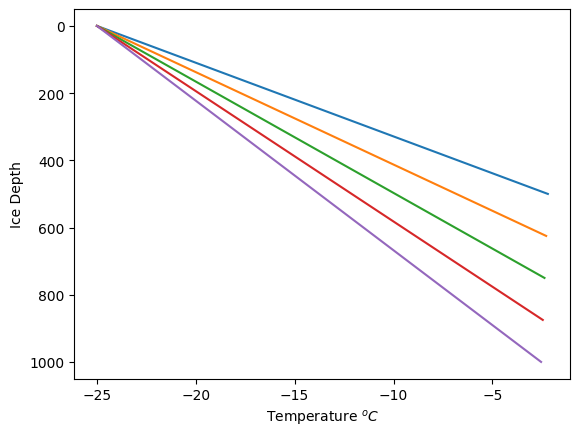

In [3]:
#Plot initialization profiles
fig, ax = plt.subplots(nrows=1, ncols=1)

for k, v in profiles_dict.items():
    ax.plot(v.temperature, v.depth, label=k+'m ice z')
    ax.set(xlabel='Temperature $^oC$', ylabel='Ice Depth')
    ax.yaxis.set_inverted(True)

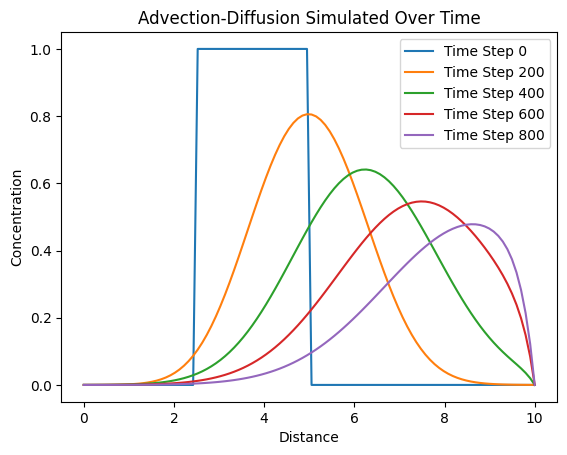

In [4]:
#Basic advection diffusion case:

u = 5         # advection velocity
D = 1.5        # diffusion coefficient
L = 10          # domain length
T = 1           # total simulation time
Nx = 100        # number of spatial points
Nt = 1000       # number of time steps

dx = L/Nx
dt = T/Nt

# Initialize concentraton array with a square wave:
c = np.zeros(Nx)
c[Nx//4:Nx//2] = 1      # from one fourth to one half of the domain length, values increase from 0 to 1. 

# Create an array to store concentrations at each time step
c_history = np.zeros((Nt, Nx))
c_history[0, :] = c # initial condition?

# Time step using finite differences
for t in range(1, Nt):
    for j in range(1, Nx - 1):
        c[j] = c[j] + u*dt/dx*(c[j-1] - c[j]) + D *dt/dx**2*(c[j+1] - 2*c[j] +c[j-1])
    c_history[t,:] = c


# Visualization
x = np.linspace(0, L, Nx)

# Plot snapshots of concnetration over time:
fig, ax = plt.subplots(nrows=1, ncols=1)
slice = 5
for t in range(0, Nt, Nt//slice):     # plot every "Nt//slice" time step
    ax.plot(x, c_history[t, :], label=f'Time Step {t}')
ax.set(xlabel='Distance', ylabel='Concentration', title='Advection-Diffusion Simulated Over Time')
plt.legend() 

## Conductivity Model
Ultimately, we are not concerned with the temperature profile of the ice because the temperature profile at Mercer Subglacial Lake (SLM) was not steep. In cases where basal temperature gradients were not anomolously steep, Neuhaus et al., 2020 employed a diffusion model, ignoring vertical advection, of the porewater ion concentrations. At SLM, we have considerably deeper ion concentrations than at Whillans Subglacial Lake (SLW). There were two phases to this model: 

### Phase 1: Seawater exposure
For some length of time, the sediments under SLM were exposed to seawater. **This is the time range that we are interested in because a time range is more interesting to modelers than just a date of seaward grounding line advance.** That length of time was denoted as $T_0$ in Neuhaus et al., 2020. 

### Phase 2: Re-grounding, basal meltwater exposure
The length of time, $T_i$ after regrounding that the sediments were exposed to basal meltwater is modeled in Phase 2. 

We use sediment porewater measurements from multicores as well as two points from porewater squeezed from a large gravity core. The diffusion coefficient was calculated using the equation from Li and Gregory (1974):
$$
D_{sed} = D \frac{\alpha}{\theta^2}
$$

We assume that $\alpha$ , a fraction close to 1, is equal to 1. We also assume that $\theta$ , toruosity, is related to the porosity by:
$$
\theta^2 = 1 - ln(\phi^2)
$$

In Neuhaus, $ \phi $ is considered to 0.4. 

The diffusion model was instantaneously switched between marine and subglacial conditions. Assuming the area was under subglacial conditions for initially 10's of thousands of years, Neuhaus et al., 2020 used an analytical solution of the following equation for each solute for which they had data: 
$$
\frac{C-C_0}{C_s-C_0} = erfc\left(\frac{y}{2\sqrt{D_{sed}t}}\right)

('Composite Depth (median)', 'cm')


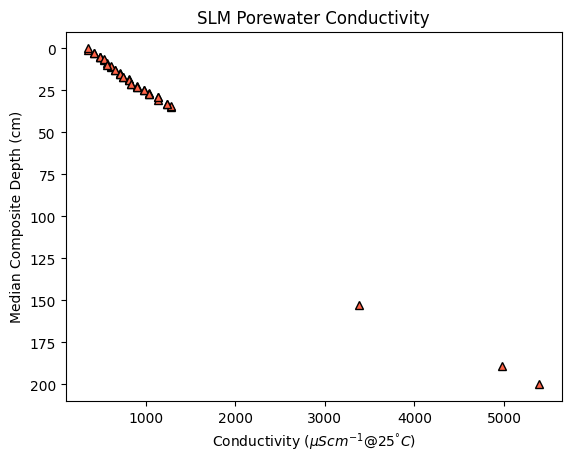

In [5]:
#Plot SLM Porewater salinity

pw_df = pd.read_excel('Davis_Supplemental_File_1.xlsx', sheet_name='Sheet1', skipfooter=3, header=[0,1])

#make plottable listes from annoying multi-index dataframe
print(pw_df.columns[3])
cond = [c for c in pw_df.loc[:, ('Conductivity', '(µS cm-1 @ 25°C)')]]
depth = [d for d in pw_df.loc[:, ('Composite Depth (median)', 'cm')]]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(cond, depth, linestyle='', marker='^', mec='k', color='tomato')
ax.yaxis.set_inverted(True)
ax.set(ylabel='Median Composite Depth (cm)', xlabel='Conductivity ($\mu S cm^{-1} @ 25^°C$)', title='SLM Porewater Conductivity')
#Construct a list of unique depths for which we have data to later calculate residuals of the A-D model:
depths_set = sorted(list(set(depth)))




In [16]:
def Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0):
    '''
    This provides the analytical solution for the phase 1 model of Neuhaus et al., 2020. The Phase 1 model assumes a straight vertical profile of 
    meltwater solute concentration or conductivity (C_0) due to isolation for tens of thousands (at least) years. There is an instantaneous change in
    boundary conditions at t = 0 to ocean water (C_1), and the model is solved for different amounts of time up to T_0. These different profiles 
    fill an output array which has a number of columns equal to the number of time slices and a number of rows equal to the depth resolution; each
    column is a verticle porewater profile.The solutions (profiles) can be uniquely calculated for a given number of years that the sediment was
    overlain by seawater (grounding line retreated landward of site).

        Input variables:
            T_0 (float): 
    
    '''
    #Make z axis (depth from 0 to L)
    Nx = L//depth_step                      # number of spatial points
    z = np.linspace(0, L, Nx)
    duration = T_0 - T_1
    #Make empty arrays of zeroes to receive the output
    conc_profiles_phase1 = np.zeros((duration//time_step, Nx))
    print('Shape of c_profiles_p1 should be ', str(T_0), '-', str(T_1), ' divided by the time step: ', conc_profiles_phase1.shape)
    init_cond = np.ones(Nx)*C_0      # initial condition is set as a straight profile at the value of C_0
    conc_profiles_phase1[0, :] = init_cond      #install initial condition in what is to become the output array

    for j, time in enumerate(range(1, conc_profiles_phase1.shape[0])):      #For every time slice except the first one (column, initial boundary condition)
        #print(j)
        for k, z in enumerate(range(0, L, depth_step)):                     #For every depth in the working time slice (works through rows)
            #print('Time:Depth:j:d = ', time, ':', c, ':', j, ':', d)
            conc_profiles_phase1[j+1, k] = math.erfc(z/(2*math.sqrt(D*time)))*(C_i-C_0)+C_0

    phase1_arr = conc_profiles_phase1.copy()
    return z, phase1_arr

def Neuhaus_PW_solute_model(boundary_condition_profile_analytical, D, T_1, C_0, L, depth_step, time_step, u=None, check_handoff=False):
    ''' 
    This solves the advection-diffusion model of phase two of the Neuhaus et al 2020 paper. It uses the output of the analytical solution from 
    seawater as the boundary condition. 
    '''
    # Initialize concentraton array with output from phase 1:
    
    boundary_cond_p2 = boundary_condition_profile_analytical[-1, :]      # The last time slice from Phase 1 corresponding to last year of open seawater contact
    boundary_cond_p2[0] = C_0

    Nx = L//depth_step                      # number of spatial points
    Nt = T_1//time_step                  # number of time steps, phase 2
    dx = L/Nx
    dt = T_1/Nt

    # Create an array to store concentrations at each time step
    readvance_cs = np.zeros((Nt, Nx))
    readvance_cs[0, :] = boundary_cond_p2 # initial condition, from phase 1
    
    # Time step using finite differences
    if u == None:
        print('Diffusion only model will be used. Specify kwarg u to add advection.')
    else:
        print('Diffusion and advection being employed.')
    p = boundary_cond_p2.copy()
    for t in range(1, Nt):
        for j in range(1, Nx - 1):
            if u == None:
                p[j] = p[j] + D *dt/dx**2*(p[j+1] - 2*p[j] +p[j-1])     #delete the advection term
            else:
                p[j] = p[j] + u*dt/dx*(p[j-1] - p[j]) + D *dt/dx**2*(p[j+1] - 2*p[j] +p[j-1])     #use advection term
                
            
        readvance_cs[t,:] = p.copy()
        phase2_arr = readvance_cs.copy()
    
    z = np.linspace(0, L, Nx)
    if check_handoff == True:
        handoff_test(boundary_condition_profile_analytical, boundary_cond_p2, readvance_cs, z)
    
    return z, phase2_arr
    

def visualize_phase1(phase1_arr, z, T_0, time_step):
    '''
    Plots curves from the array of Phase 1 profiles, the initial condition, the final condition (initial condition 
    for Phase 2), and 3 from the middle. 


    '''

    fig, ax = plt.subplots(nrows=1, ncols=1)

    #xes = np.linspace(0, max_depth, max_depth//depth_step)
    cols = [0, len(phase1_arr[:,0])//3, len(phase1_arr[:, 0])//3*2, -2, -1]
    for ind, t in enumerate(cols):
        if t==0:
            name = 'Initial Cond.'
        elif t==-1:
            name = 'Final Cond.'
        else:
            name = str(T_0 - t*time_step)+' ybp'
        ax.plot(phase1_arr[t, :], z, label=name)
    
    ax.yaxis.set_inverted(True)
    ax.set(
        title='Phase 1, '+str(T_0) + '-' + str(len(phase1_arr[:,0])*time_step)+'ybp',
        ylabel='depth (cm)',
        xlabel='Conductivity ($\mu S cm^{-1} @ 25^°C$)'
    )
    plt.legend()

    return fig, ax

def visualize_phase2(phase_2_profiles, pw_df, z, slice=5):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    cond = [c for c in pw_df.loc[:, ('Conductivity', '(µS cm-1 @ 25°C)')]]
    depth = [d for d in pw_df.loc[:, ('Composite Depth (median)', 'cm')]]

    Nt = phase_2_profiles.shape[0]
    print('Nt = ', Nt)
    #Plot Phase 2 only:
    for t in range(0, Nt, Nt//slice):
        # plot every "Nt//slice" time step from model
        print('Time step: ', str(Nt-t))
        ax[0].plot(phase_2_profiles[t, :], z, label=f'{Nt-t}'+'ybp')
    #Add observations:
    ax[0].plot(cond, depth, linestyle='', marker='^', markersize=10, mec='k', color='tomato')
    #Add final time step from model:
    ax[0].plot(phase_2_profiles[-1, :], z, color='k', linewidth=2, label='Final step')
    ax[0].set(ylabel='depth (cm)', title='Ph. 2 A-D '+str(Nt)+'-0 ybp')
    ax[0].yaxis.set_inverted(True)
    ax[0].legend() 

    #Plot Phase 2, zoomed with data and only last iteration of the model:
    ax[1].plot(cond, depth, linestyle='', marker='^', markersize=10, mec='k', color='tomato')
    ax[1].plot(phase_2_profiles[-1, :], z, color='k', linewidth=2)
    ax[1].set(title='Mod vs. Data', ylim=[0, 250])
    ax[1].yaxis.set_inverted(True)

    fig.supxlabel('Conductivity ($\mu S cm^{-1} @ 25^°C$)')

    return fig, ax

def visualize_allphases(c_profiles_p1, phase_2_profiles, pw_df, T_0, T_1, Nt_T0, Nt_T1, z, slice=5):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    cond = [c for c in pw_df.loc[:, ('Conductivity', '(µS cm-1 @ 25°C)')]]
    depth = [d for d in pw_df.loc[:, ('Composite Depth (median)', 'cm')]]

    #Plot Phase 1:
    for t in range(0, Nt_T0, Nt_T0//slice):
        # plot every "Nt//slice" time step from model
        ax[0].plot(c_profiles_p1[t, :], z, label=f'{T_0-t}'+'ybp')
    #Add observations:
    ax[0].plot(cond, depth, linestyle='', marker='^', markersize=10, mec='k', color='tomato')
    #Add final time step from model:
    ax[0].plot(c_profiles_p1[-1, :], z, color='k', linewidth=2, label='Bndry Cond. Phase 2')
    ax[0].set(ylabel='depth (cm)', title='Ph. 1: Retreat')
    ax[0].yaxis.set_inverted(True)
    ax[0].legend() 

    #Plot Phase 2:
    for t in range(0, Nt_T1, Nt_T1//slice):
        # plot every "Nt//slice" time step from model
        ax[1].plot(phase_2_profiles[t, :], z, label=f'{T_1-t}'+'y')
    #Add observations:
    ax[1].plot(cond, depth, linestyle='', marker='^', markersize=10, mec='k', color='tomato')
    #Add final time step from model:
    ax[1].plot(phase_2_profiles[-1, :], z, color='k', linewidth=2, label='Present')
    ax[1].set(ylabel='depth (cm)', title='Ph. 2: Advance')
    ax[1].yaxis.set_inverted(True)
    ax[1].legend() 

    #Plot Phase 2, zoomed in with data
    ax[2].plot(cond, depth, linestyle='', marker='^', markersize=10, mec='k', color='tomato')
    ax[2].plot(phase_2_profiles[-1, :], z, color='k', linewidth=2)
    ax[2].set(title='Mod vs. Data', ylim=[0, 250])
    ax[2].yaxis.set_inverted(True)

    fig.supxlabel('Conductivity ($\mu S cm^{-1} @ 25^°C$)')

    return fig, ax

def handoff_test(boundary_condition_profile_analytical, boundary_cond_p2, readvance_cs, z):
    '''
    Designed to work within the Neuhaus Solute Model function. Shows the length of the final time slice of the numerical solution that is
    an argument of the model, the first column of the output array, and  the final output of the model's initial condition. These 
    should be the same. A plot is made with the final time slice of the input array and the first time slice of the output array. Again, 
    these should be the same. 

    '''

    print('Length and first 10 elements of final time slice of input array (analytical solution): ', len(boundary_condition_profile_analytical[:, -1]), boundary_condition_profile_analytical[-1, 0:10])
    print('Length and first 10 elements of hand-off to solute transport model output: ', len(boundary_cond_p2), boundary_cond_p2[0:10])
    print('Length and first 10 elements of the first time slice of the solute transport model output, after iterative loop: ', len(readvance_cs[:, 0]), readvance_cs[0, 0:10])

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(boundary_condition_profile_analytical[-1, :], z, marker='o', markersize=15, linestyle='', mfc='lemonchiffon', mec='k', label='Input profile')
    ax.plot(boundary_cond_p2, z, marker=None, linestyle='-', linewidth=5, color='w', label='Hand-off profile')
    ax.plot(readvance_cs[0, :], z, marker=None, linestyle='--', linewidth=1, color='k', label='Initial condition output')
    ax.set(title='Hand-off Test - All plots should be same!', xlabel='Conductivity ($\mu S cm^{-1} @ 25^°C$)', ylabel='Depth, cm')
    plt.legend()
    ax.yaxis.set_inverted(True)

    return fig, ax





Number of time steps in Phase 2:  4000
Shape of c_profiles_p1 should be  10000 - 4000  divided by the time step:  (6000, 200)
Diffusion and advection being employed.
Shape of phase_2_profiles =  (4000, 200)
Nt =  4000
Time step:  4000
Time step:  3200
Time step:  2400
Time step:  1600
Time step:  800


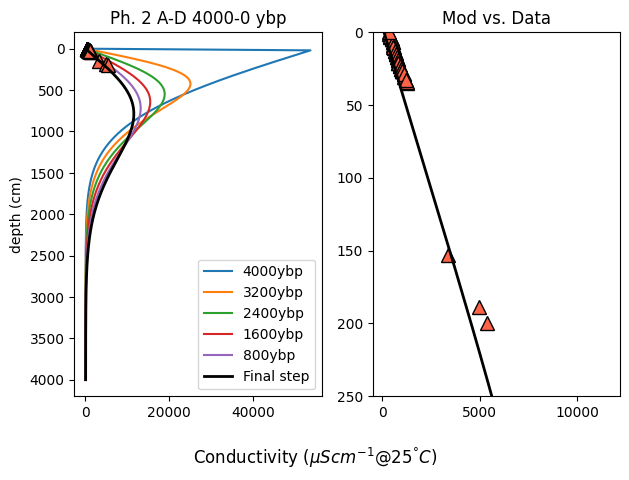

In [20]:
#Top level variables
phi = 0.4                               #Neuhaus et al. approximation, constant in their work
D_Cl = 0.0113*100*100                   #cm^2/y, Diffusivity of chloride ion, Table 2 of Neuhaus et al., 2020
D_Ca = 0.00416*100*100                  #Cm^2/y, Diffusivity of calcium ion, Table 2 of Neuhaus et al., 2020

u = 0.0001                              #Advection velocity if decide to incorporate advection
L = 4000                                #cm, max depth in centimeters, in Neuhaus et al., 2020 it was 10000 cm
depth_step = 20                         #cm, depth step is the vertical resolution which was 50 cm in Neuhaus et al., 2020
time_step = 1                           #year, time resolution to run the analytical model
C_0 = 100                               #microseimens per centimeter @25 degrees C. 
C_i = 55000                             #microseimens per centimeter for seawater
Nx = L//depth_step                      # number of spatial points

#Phase-level variables
#Phase 1: Analytical solution - solute diffusion:
T_0 = 10000                              #number of years phase 1 - How many years is the site open to seawater
Nt_T0 = T_0//time_step                  # number of time steps, phase 1

#Phase 2 - Finite difference diffusion model
T_1 = 4000                         #Number of years after readvance, and to present. How long ago did grounding line advace past SLM?
Nt_T1 = T_1//time_step                  # number of time steps, phase 2
print('Number of time steps in Phase 2: ', Nt_T1)

#derived values
dx = L/Nx
dt_0 = T/Nt
dt_1 = T/Nt

#Run Phase 1 Model:
#Set diffusion coefficient:
D = (1/(1-math.log(phi**2)))*D_Cl
#D = D_Cl
xes, c_profiles_p1 = Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0)

#Run Phase 2 Model:
z, phase_2_profiles = Neuhaus_PW_solute_model(c_profiles_p1, D, T_1, C_0, L, depth_step, time_step, u=0.02, check_handoff=False)
print('Shape of phase_2_profiles = ', phase_2_profiles.shape)

#Plot both phases:
#fig, ax = visualize_allphases(c_profiles_p1, phase_2_profiles, pw_df, T_0, T_1, Nt_T0, Nt_T1, z, slice=5)


#Plot Phase 2 Model:
fig, ax = visualize_phase2(phase_2_profiles, pw_df, z, slice=5)
plt.tight_layout()


In [8]:
def modify_array(arr):
    arr[0] = 99  # This modification will only affect the copy

original_array = np.array([1, 2, 3])
copied_array = original_array.copy()  # Create a copy
bad_coppied_array = original_array
modify_array(copied_array)
bad_coppied_array[0] = -99

print(f"Original array: {original_array}")
print(f"Modified copy: {copied_array}")
print(f"Viewed copy: {bad_coppied_array}")


Original array: [-99   2   3]
Modified copy: [99  2  3]
Viewed copy: [-99   2   3]


In [14]:
print(dt)

0.001


Shape of c_profiles_p1 should be  6300 - 3200  divided by the time step:  (3100, 200)
<class 'numpy.ndarray'>
Diffusion and advection being employed.
Nt =  3200
Time step:  3200
Time step:  2560
Time step:  1920
Time step:  1280
Time step:  640


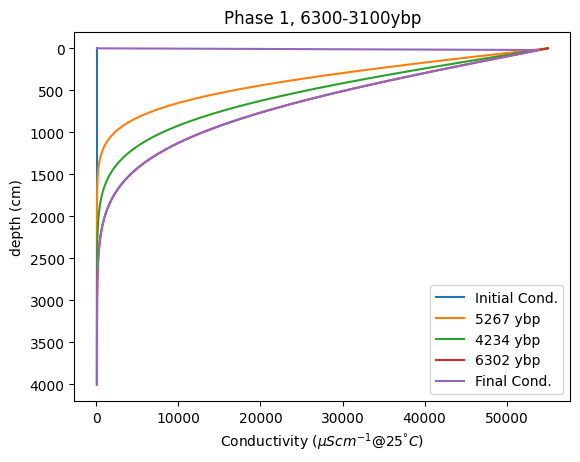

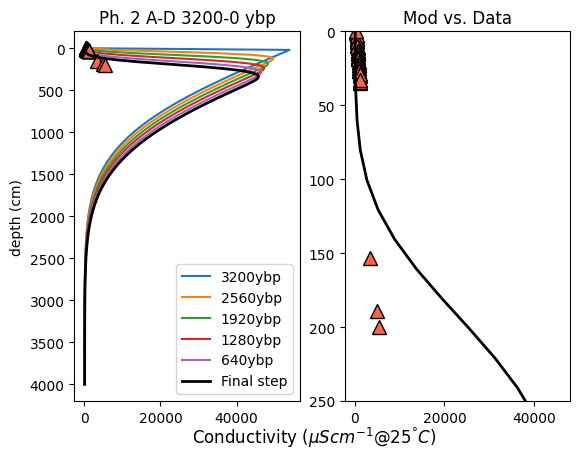

In [15]:
#Phase 1 Practice:

L = 4000                                #cm depth scale, sediment
depth_step = 20                         #cm, depth resolution of calculations
T = 1700                                #years, amount of time that the system is open to the ocean
D = 0.0113*100*100                      #cm^2/y, Diffusivity of chloride ion, Table 2 of Neuhaus et al., 2020



Nx = L//depth_step                      # number of spatial points
z = np.linspace(0, L, Nx)

xes, phase1_arr = Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0)
print(type(phase1_arr))
z, phase_2_profiles = Neuhaus_PW_solute_model(phase1_arr, D, T_1, C_0, L, depth_step, time_step, u=60, check_handoff=False)


#Plot initial profile and some other time slices from Phase 1:
fig, ax = visualize_phase1(phase1_arr, z, T_0, time_step)

fig_diff, ax_diff = visualize_phase2(phase_2_profiles, pw_df, z, slice=5)

## Feeding a changing baseline to the advection/diffusion model

In the above example, a square wave is implanted in a sequence and then changed over time through advection and diffusion. The implication is that the square wave was implemented at a much higher rate than the time steps in the model. But what if the square wave took many time steps to develop and to return to baseline, all the while diffusion and advection happening to it? Mathematically, this is making the time steps smaller than the implementation of the square wave, but computationally, we can explore this scenario by changing the baseline with each time step.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
200


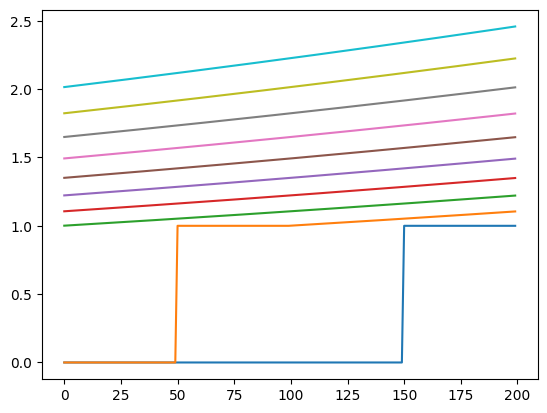

In [10]:
# Initialize concentraton array with a square wave:
c = np.zeros(Nx)
c[Nx//4*3:] = 1      # from three fourths to the end of C is 1 - square wave.
print(c)

# Create an array to store concentrations at each time step
c_history = np.zeros((Nt, Nx))
c_history[0, :] = c # initial condition?

for t in range(1, Nt):
    if t > 0:
        c = c[1:]       #get rid of first concentration
        c = np.append(c, (c[-1])*1.001)
    #for j in range(1, Nx - 1):
    #    c[j] = c[j] + u*dt/dx*(c[j-1] - c[j]) + D *dt/dx**2*(c[j+1] - 2*c[j] +c[j-1])
    c_history[t,:] = c

fig, ax = plt.subplots(nrows=1, ncols=1)
slice = 10
for t in range(0, Nt, Nt//slice):     # plot every "Nt//slice" time step
    ax.plot(c_history[t, :], label=f'Time Step {t}')

print(len(c_history[3,:]))
